In [345]:
# author : Myron Kukhta (xkukht01)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from abc import ABC, abstractmethod


In [346]:
class LR(ABC):
    def __init__(self):
        '''
        Constructor
        
        Attributes:
            _y          [np.array]: independet var
            _y_predict  [np.array]: predicted independet var
            _e          [np.array]: errors of prediction
            _dataframe  [pd.DataFrame]: dataset in pandas dataframe
            _R_2        [float]: coeficient of Determination
        '''
        self._y = None
        self._y_predict = None
        self._e = None
        self._dataset = None
        self._R_2 = None

    def _Load_data_set(self, path:str)->None:
        '''
        
        Load dataset from csv to DataFrame

        '''
        full_path = os.path.join(os.getcwd(), path)
        
        if not os.path.isfile(full_path):  # check is file with dataset exist
            raise Exception(f'Error! File with dataset on path "{path}" is not exist')
        
        self._dataset= pd.read_csv(full_path)  # store dataset to dataframe
        
        if self._dataset.empty:  # check is dataframe not empty
            raise Exception(f'Waring! Data set on path "{path}" is empty. Counting is aborted.')


        self._dataset.to_excel(f'dataset/dataset.xlsx', index=True)  # store output
    
    @abstractmethod
    def _Sampling(self)->None:
        '''
        Abstract class for choosing dependet and independet var from dataframe to analys
        '''
        pass

    @abstractmethod
    def Vizualization(self)->None:
        '''
        Abstract class for vizualization output
        '''
        pass

    def _Evaluation(self)->None:
        '''
        Evaluation of correlation between dependet/s and independet vars

                ERROR = Y - Y_predict
                R_2 = 1 - SS_res/SS_tos

        '''
        self._e = self._y - self._y_predict
        
        # residual sum of squares
        SS_res = np.sum(np.power(self._e, 2))
        # total sum of squares
        SS_tos = np.sum(np.power((self._y-self._y_avg), 2))

        # coeficient of Determination
        self._R_2 = 1 - SS_res/SS_tos
    
    @abstractmethod
    def _Linear_regression(self)->None:
        '''
        Abstarct class for realization linear regression algorithm
        '''
        pass

In [347]:
class SLR(LR):
    '''
    
    Class for implementing a Simple Linear Regression(SLR) algorithm

    '''
    def __init__(self):
        super().__init__()
        self._solution = pd.DataFrame(columns=['sample_size', 'Y', 'Pr Y', 'A', 'B'])
        self._eval = pd.DataFrame(columns=['E', 'X*E', 'r', 'R^2'])
        self._x = None
        self._x_avg = None
        self._y_avg = None
        self._a = None
        self._b = None
        self._r = None
        

    def _Sampling(self)->None:
        # check data
        if not self._x_name in self._dataset.columns:
            raise Exception(f'Column "{self._x_name}" is not exist in actual dataframe!')
        
        if not self._y_name in self._dataset.columns:
            raise Exception(f'Column "{self._y_name}" is not exist in actual dataframe!')
        
        if not pd.to_numeric(self._dataset[self._x_name], errors='coerce').notnull().all():
            raise Exception(f'Column "{self._x_name}" have literal values and can not be used in experiment!')
        
        if not pd.to_numeric(self._dataset[self._y_name], errors='coerce').notnull().all():
            raise Exception(f'Column "{self._y_name}" have literal values and can not be used in experiment!')

        # choose data
        self._x = self._dataset[self._x_name].values
        self._y = self._dataset[self._y_name].values
    
    def Vizualization(self)->None:
        plt.scatter(self._x, self._y, marker='o', color='blue', label='data')  # original relation

        plt.axis([self._x.min()-10, self._x.max()+10, self._y.min()-10, self._y.max()+10])
        
        plt.plot(self._x, self._y_predict, color='red', label='prediction')  # prediction

        #if with_err:  # viz relation between predicted and real Y
        #    point = 0
        #    lab = 'error'
        #    for x_it, y_it, y_pr_it, e_it in np.nditer([self._x, self._y, self._y_predict, self._e]):  # one time iteration on many np arrays
        #        point += 1
        #        plt.plot([x_it, x_it], [y_pr_it, y_pr_it+e_it], color='green', label=lab)  # e = y_real - y_predict
        #        lab=None
        plt.axhline(y=np.mean(self._y), color='black', linestyle='--', label='weight center')
        plt.axvline(x=np.mean(self._x), color='black', linestyle='--')

        plt.xlabel(self._x_name)
        plt.ylabel(self._y_name)
        plt.title('SLR')
        plt.legend()
        plt.show()

    def _Linear_regression(self)->None:
        '''
        Description:

        Y_PREDICT = a + b*X

        a = avg(Y) - b*X

                sum((X-avg(X))*(Y-avg(Y)))
        b = -------------------------
                sum((X-avg(X))**2)

        '''
        
        # avg of dependet and independet var
        self._x_avg = np.mean(self._x)
        self._y_avg = np.mean(self._y)

        self._b = np.sum(np.multiply((self._x - self._x_avg), (self._y - self._y_avg)))/np.sum(np.power((self._x - self._x_avg), 2))
        
        self._a = self._y_avg - self._b*self._x_avg

        self._y_predict = self._a + self._b*self._x

    
    def _Evaluation(self)->tuple[float, float]:
        '''
        Evaluation of correlation between dependet and independet vars

                    avg(X*Y) - avg(X)*avg(Y)
                r = --------------------------
                    sqrt((avg(X**2)-avg(X)**2)*(avg(Y**2)-avg(Y)**2))

                R_2 = 1 - SS_res/SS_tos
    
        '''
        super()._Evaluation()
        # correlation coeficient
        self._r = (np.mean(np.multiply(self._x, self._y)) - self._x_avg*self._y_avg)/np.sqrt((np.mean(np.power(self._x,2))-self._x_avg**2)*(np.mean(np.power(self._y,2))-self._y_avg**2))
        
        

    def SLR(self, path:str, x_name:str, y_name:str)->None:
        '''
            Simple linear regression process.

        '''
        self._x_name, self._y_name = x_name, y_name
        self._solution.drop(self._solution.index,inplace=True)
        self._eval.drop(self._eval.index,inplace=True)
        self._Load_data_set(path)
        self._Sampling()
        
        self._Linear_regression()

        self._solution.loc[len(self._solution)] = {'sample_size':self._x.size, 'Y':np.sum(self._y), 'Pr Y':np.sum(self._y_predict), 'A': self._a, 'B': self._b}   # store output of actual expiriment
        
        print(self._solution)
        # evaluation
        self._Evaluation()
        self._eval.loc[len(self._eval)] = {'E':np.sum(self._e), 'X*E':np.sum(np.multiply(self._x, self._e)), 'r': self._r, 'R^2':self._R_2}
        print(self._eval)


In [348]:
class OLR(LR):
    def __init__(self):
        super().__init__()
        self._x = None
        self._x_names = None
        self._y_name = None
        self._solution = pd.DataFrame(columns=['sample_size', 'Y', 'Pr Y'])
        self._B = None
        self._eval = pd.DataFrame(columns=['E', 'R^2'])

    def _Sampling(self)->None:
        '''
        Abstract class for choosing dependet and independet var from dataframe to analys
        '''
        for x_name in self._x_names:
            if x_name not in self._dataset.columns:
                 raise Exception(f'Column "{x_name}" is not exist in actual dataframe!')

        
        if self._y_name not in self._dataset.columns:
                raise Exception(f'Column "{self._y_name}" is not exist in actual dataframe!')

        for x_name in self._x_names:
            if not pd.to_numeric(self._dataset[x_name], errors='coerce').notnull().all():
                raise Exception(f'Column "{x_name}" have literal values and can not be used in experiment!')
        
        if not pd.to_numeric(self._dataset[self._y_name], errors='coerce').notnull().all():
            raise Exception(f'Column "{self._y_name}" have literal values and can not be used in experiment!')

        
        # choose data
        self._x = self._dataset[self._x_names].values
        self._y = self._dataset[self._y_name].values

    def Vizualization(self)->None:
        '''
        Abstract class for vizualization output
        '''
        pass

    def _Evaluation(self)->None:
        '''
        Evaluation of correlation between dependet/s and independet vars

                ERROR = Y - Y_predict
                R_2 = 1 - SS_res/SS_tos

        '''
        return super()._Evalation()
    def _Linear_regression(self)->None:
        '''
        Ordinary least squere process
            b = ((X^T*X)^-1)*X^T*y
        '''
        ones_arr = np.ones(self._x.shape[0])
        self._x = np.column_stack((ones_arr, self._x))
        x_t = np.transpose(self._x)
        x_t_mul_x =np.linalg.inv(np.dot(x_t,self._x))
        self._B = np.dot(np.dot(x_t_mul_x, x_t), self._y)
        print(self._B)
        
    def OLR(self, path, x_names, y_name:str):
        self._x_names, self._y_name = x_names, y_name
        self._solution.drop(self._solution.index, inplace=True)
        self._Load_data_set(path)
        self._Sampling()
        self._Linear_regression()

In [349]:
# object for Simple linear regression

SLR_solution = SLR()

   sample_size         Y      Pr Y          A         B
0          365  19017.82  19017.82 -33.698166  1.192009
              E           X*E         r       R^2
0 -6.769696e-12 -4.704361e-10  0.988446  0.977025


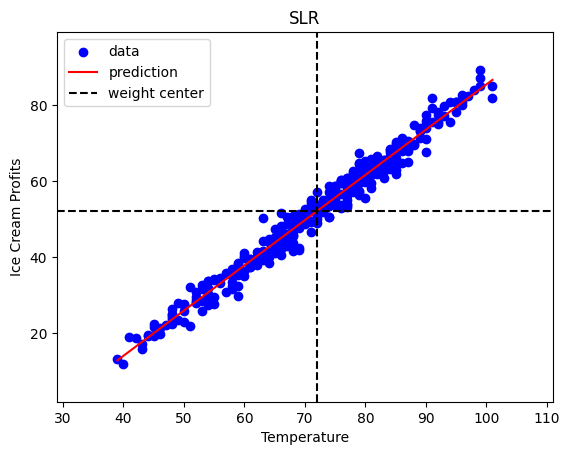

In [350]:
# Experiment № 1
# Description: SLR with ideal data from 2-d dataset

SLR_solution.SLR('dataset/ice_cream.csv', 'Temperature', 'Ice Cream Profits')
SLR_solution.Vizualization()

   sample_size       Y      Pr Y          A       B
0         2040  149092  149092.0  44.984073  0.2204
              E           X*E         r       R^2
0  3.694822e-12  2.801244e-10  0.756042  0.571599


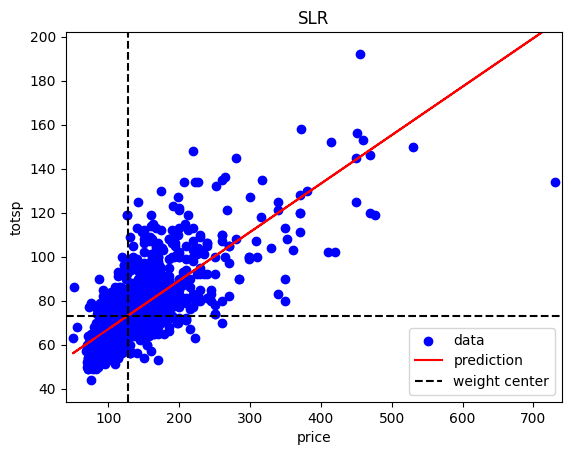

In [351]:
# Experiment № 1
# Description: SLR with dirty data from N-d dataset

SLR_solution.SLR('dataset/flats.csv', 'price', 'totsp')
SLR_solution.Vizualization()

   sample_size       Y      Pr Y         A         B
0         2040  149092  149092.0 -3.456116  1.651812
              E           X*E         r      R^2
0  8.753887e-12  3.810783e-10  0.862236  0.74345


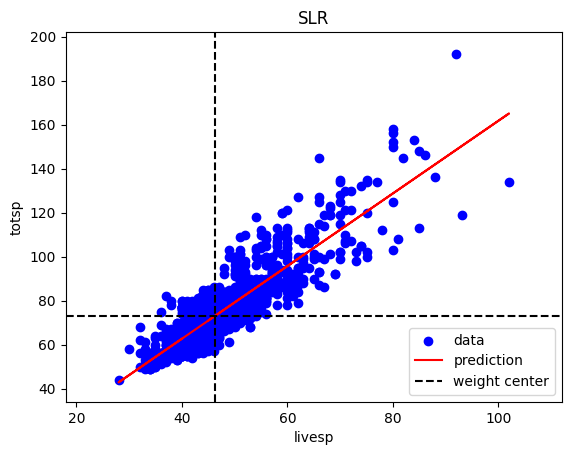

In [352]:

SLR_solution.SLR('dataset/flats.csv', 'livesp', 'totsp')  # livesp better
SLR_solution.Vizualization()

   sample_size       Y      Pr Y          A         B
0         2040  149092  149092.0  78.745091 -0.513883
              E           X*E         r       R^2
0  1.352873e-11  1.573426e-10 -0.114698  0.013156


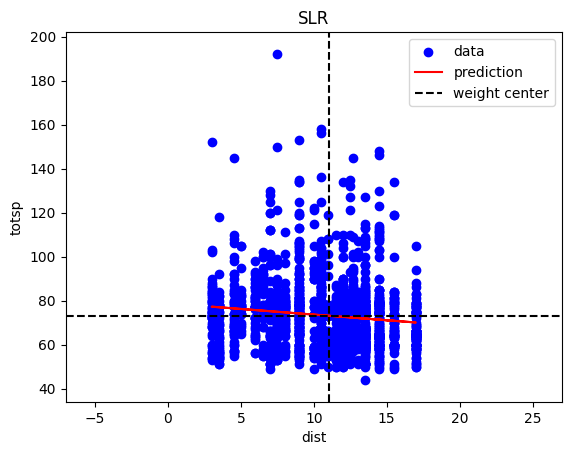

In [353]:
SLR_solution.SLR('dataset/flats.csv', 'dist', 'totsp')  # livesp better
SLR_solution.Vizualization()

In [354]:
OLR_solution = OLR()

In [355]:
OLR_solution.OLR('dataset/flats.csv', ['price', 'livesp', 'dist'], 'totsp')

[-2.6588475   0.0931676   1.25044209  0.53764767]
